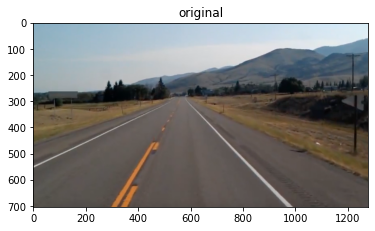

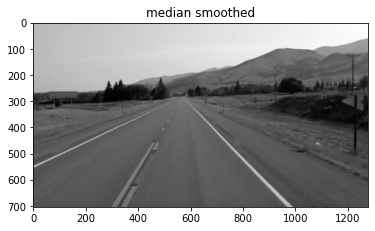

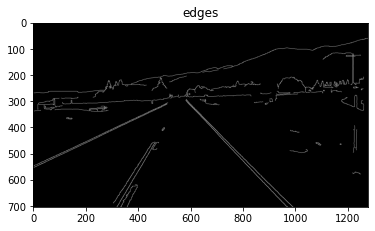

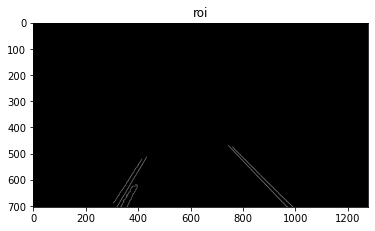

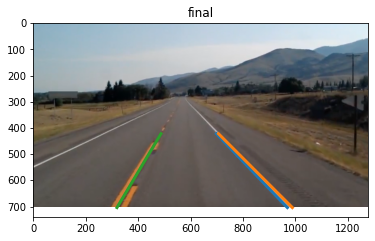

In [114]:
# imports (obviously)

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line_peaks

# load image

# load image, GBR
original=cv2.imread('lane.png')

# change to RGB
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.imshow(original)
plt.title('original')
plt.show()


# change to gray scale
img = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.title('gray scale')
plt.show()

# apply median smoothing

img = cv2.medianBlur(img,3)
plt.imshow(img,cmap='gray')
plt.title('median smoothed')
plt.show()

# detect edges
edges = cv2.Canny(img,50,150)
plt.imshow(edges,cmap='gray')
plt.title('edges')
plt.show()

# Focus on region of interest
# change this should we want the line to be longer, or include more lanes

height,width = edges.shape
roi_vertices = [(0,height),(5*width/10,6*height/10),(width,height)]
mask = np.zeros(edges.shape)
poly = np.array([roi_vertices], dtype=np.int32)
cv2.fillPoly(mask, poly, 255)
roi = np.multiply(edges,mask)
plt.imshow(roi,cmap='gray')
plt.title('roi')
plt.show()

# Get points where roi != 0 for hough votes

active_Y,active_X = np.where(roi != 0)
# rearrange to tuples of (x,y)
active_points = [(x,y) for (x,y) in zip(active_X,active_Y)]



# time for the hough transform

# the max rho value would be the length of the diagonal
r_max = np.round(np.sqrt(height**2+width**2)).astype('int32')

# generate all rhos from 0 - r_max
rs = np.arange(-r_max,r_max)

# generate thetas, 0-180 with 0.1 deg intervals (dec : more acc, but more computation)
thetas = np.arange(0,180,0.1)

# convert thetas to radians
thetas = np.deg2rad(thetas)

# hough space
H = np.zeros((len(rs),len(thetas)))

for x,y in active_points:
    for t,theta in enumerate(thetas): 
        r = int(np.round((x * np.cos(theta) + y * np.sin(theta))))
        # values vary from -r_max to r_max
        # + r_max to get index
        # so -r_max is @ index 0, r_max @ index -1
        r += r_max
        H[r, t] += 1



# get peaks

H,max_thetas,max_rs = hough_line_peaks(H,thetas,rs,threshold=None)


# create a line for each theta
# each line has co-ordinates for 2 points : (x1,y1),(x2,y2)

lines=np.zeros((len(max_thetas),4), dtype=np.int32) 

# for each line we generate points that fit in our roi
roi_verticies = np.array(roi_vertices)

# define our y ponts in roi
y1 = int(roi_verticies[1,1]) # top of roi polygon
y2 = int(roi_verticies[0,1]) # bottom of roi polygon

for i,(r,theta) in enumerate(zip(max_rs,max_thetas)):

    a,b = np.cos(theta),np.sin(theta)
    # the line defined by r and theta is perp to our desired line
    # and its gradient is equal to tan theta = b/a
    # by geometry we know that the product of the gradient of 2 perp lines = -1
    # so gradient of our line = - a/b
    m = -a/b
    # the since our line is perp to line defined by r and th
    x,y = r*a,r*b
    
    # now we need to define how much x moves to reach x1 when y goes to y1
    # recall the gradient, -a/b is ratio between steps moved by y to those of x
    # so for each b steps x moves , y moves -a steps
    # so if y moves y1-y, how much does x move ?
    #  y   :  x
    #  -a  :  b
    # y1-y :  ?
    # ? = (y1-y)*b/-a = (y1-y)/m
    # same goes for x2 and y2
    
    offset = (y1-y)/m
    x1 =int(x + offset)
    
    offset = (y2-y)/m
    x2 = int(x + offset)
    
    lines[i]= x1,y1,x2,y2


for line in lines:
    x1,y1,x2,y2 = line
    x = [x1, x2]
    y = [y1, y2]
    plt.plot(x, y, linewidth=3)
plt.imshow(original)
plt.title('final')
plt.show()

